# Principal-Component Analysis

**Principal-component analysis**, or **PCA**, is a technique for taking a dataset consisting of a set of tuples representing points in a high-dimensional space and *finding* the directions along which the tuples have the greatest variance. 

In [4]:
%matplotlib inline

import matplotlib
import numpy as np
from numpy.linalg import eig
import numpy.linalg as linalg
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patheffects
from mpl_toolkits.mplot3d import Axes3D

np.random.seed(0)

def center_spines(ax=None, centerx=0, centery=0):
    """Centers the axis spines at <centerx, centery> on the axis "ax", and
    places arrows at the end of the axis spines."""
    if ax is None:
        ax = plt.gca()

    # Set the axis's spines to be centered at the given point
    # (Setting all 4 spines so that the tick marks go in both directions)
    ax.spines['left'].set_position(('data', centerx))
    ax.spines['bottom'].set_position(('data', centery))
    ax.spines['right'].set_position(('data', centerx - 1))
    ax.spines['top'].set_position(('data', centery - 1))

    # Draw an arrow at the end of the spines
    ax.spines['left'].set_path_effects([EndArrow()])
    ax.spines['bottom'].set_path_effects([EndArrow()])

    # Hide the line (but not ticks) for "extra" spines
    for side in ['right', 'top']:
        ax.spines[side].set_color('none')

    # On both the x and y axes...
    for axis, center in zip([ax.xaxis, ax.yaxis], [centerx, centery]):
        # Turn on minor and major gridlines and ticks
        axis.set_ticks_position('both')
        axis.grid(True, 'major', ls='solid', lw=0.5, color='gray')
        axis.grid(True, 'minor', ls='solid', lw=0.1, color='gray')
        axis.set_minor_locator(mpl.ticker.AutoMinorLocator())

        # Hide the ticklabels at <centerx, centery>
        formatter = CenteredFormatter()
        formatter.center = center
        axis.set_major_formatter(formatter)

    # Add offset ticklabels at <centerx, centery> using annotation
    # (Should probably make these update when the plot is redrawn...)
    xlabel, ylabel = map(formatter.format_data, [centerx, centery])
    ax.annotate('(%s, %s)' % (xlabel, ylabel), (centerx, centery),
            xytext=(-4, -4), textcoords='offset points',
            ha='right', va='top')

# Note: I'm implementing the arrows as a path effect rather than a custom 
#       Spines class. In the long run, a custom Spines class would be a better
#       way to go. One of the side effects of this is that the arrows aren't
#       reversed when the axes are reversed!

class EndArrow(mpl.patheffects._Base):
    """A matplotlib patheffect to add arrows at the end of a path."""
    def __init__(self, headwidth=5, headheight=5, facecolor=(0,0,0), **kwargs):
        super(mpl.patheffects._Base, self).__init__()
        self.width, self.height = headwidth, headheight
        self._gc_args = kwargs
        self.facecolor = facecolor

        self.trans = mpl.transforms.Affine2D()

        self.arrowpath = mpl.path.Path(
                np.array([[-0.5, -0.2], [0.0, 0.0], [0.5, -0.2], 
                          [0.0, 1.0], [-0.5, -0.2]]),
                np.array([1, 2, 2, 2, 79]))

    def draw_path(self, renderer, gc, tpath, affine, rgbFace):
        scalex = renderer.points_to_pixels(self.width)
        scaley = renderer.points_to_pixels(self.height)

        x0, y0 = tpath.vertices[-1]
        dx, dy = tpath.vertices[-1] - tpath.vertices[-2]
        azi =  np.arctan2(dy, dx) - np.pi / 2.0 
        trans = affine + self.trans.clear(
                ).scale(scalex, scaley
                ).rotate(azi
                ).translate(x0, y0)

        gc0 = renderer.new_gc()
        gc0.copy_properties(gc)
        self._update_gc(gc0, self._gc_args)

        if self.facecolor is None:
            color = rgbFace
        else:
            color = self.facecolor

        renderer.draw_path(gc0, self.arrowpath, trans, color)
        renderer.draw_path(gc, tpath, affine, rgbFace)
        gc0.restore()

class CenteredFormatter(mpl.ticker.ScalarFormatter):
    """Acts exactly like the default Scalar Formatter, but yields an empty
    label for ticks at "center"."""
    center = 0
    def __call__(self, value, pos=None):
        if value == self.center:
            return ''
        else:
            return mpl.ticker.ScalarFormatter.__call__(self, value, pos)

In [5]:
def processParams(A, c, title):
    As = A if type(A) is list else [A]
    n = len(As)
    
    titles = title if type(title) is list else (title for i in range(n))
    colors = c if type(c) is list else (c for i in range(n))
    
    return n, As, colors, titles
    

def plotMatrix(A, c='blue', title=''):
    n, As, colors, titles = processParams(A, c, title)
    
    f, axarr = plt.subplots(1, n, figsize=(4*n, 4*n))
    if n == 1:
        axarr = [axarr]
        
    for i, A, color, title in zip(range(n), As, colors, titles):
        ax = axarr[i]
        #plt.plot(A[:,0], A[:,1], 'ro', markersize = 3)
        ax.scatter(A[:,0].A1, A[:,1].A1, s = 5, c = color, edgecolors="face")
        ax.set_aspect('equal', adjustable='box')
        ax.set_xlim(-15, 15)
        ax.set_ylim(-15,15)
        center_spines(ax)
        ax.set_title(title)
        
    plt.show()
    
def plot3DMatrix(A, c='blue', title=''):
    n, As, colors, titles = processParams(A, c, title)

    # Twice as wide as it is tall
    fig = plt.figure(figsize=plt.figaspect(0.5))

    for i, A, color, title in zip(range(n), As, colors, titles):
        ax = fig.add_subplot(1, n, i+1, projection='3d')
        ax.scatter(A[:,0].A1, A[:,1].A1, A[:,2].A1, zdir="y", c = color, edgecolors="face", s=5)
        ax.set_xlabel('X')
        ax.set_ylabel('Z')
        ax.set_zlabel('Y')
        ax.set_title(title)

    plt.show()  

# Eigenvectors and Eigenvalues

An **eigenvector** is a vector whose direction remains unchanged when a linear transformation is applied to it.

Let A represent the transformation, and e be an eigenvector.  Then 
$$Ae = \lambda e$$

Please note that λ is a constant, and so the direction of Ae will remain unchanged.

In [6]:
A = np.matrix([[2,0], [0,0.5]])
print A

[[ 2.   0. ]
 [ 0.   0.5]]


In [21]:
evalues, evectors = eig([A])
print "Eigenvalues:"
print evalues

print 
print "Eigenvectors:"
print evectors


Eigenvalues:
[[ 2.   0.5]]

Eigenvectors:
[[[ 1.  0.]
  [ 0.  1.]]]


In [22]:
# Let's try the first vector
e = evectors[0,0].reshape(-1,1)
lambdaValue = evalues[0,0]
print "Ae:"
print A * e
print
print "λe:"
print lambdaValue * e

Ae:
[[ 2.]
 [ 0.]]

λe:
[[ 2.]
 [ 0.]]


In [23]:
u = np.random.normal(0, 4, 100)
v = np.random.normal(0, 1, 100)
x = u + v
y = u - v
M = np.matrix(zip(x,y))
C = np.cov(M, rowvar=0) # set rowvar=0, meaning each col in A is a variable, and each row is an observation
print "Covariance Matrix:"
print C

Covariance Matrix:
[[ 16.42489199  13.77499278]
 [ 13.77499278  14.61479432]]


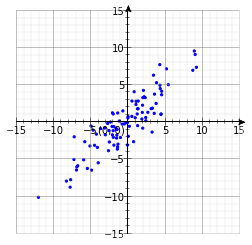

In [24]:
plotMatrix(M)

### Covariance and M'M

Please note that if M is mean centered (value in each dimension = (v-mean), where mean is the mean of the values in that dimension), then

`covariance of M = M'M / (n-1)` 

where n is the number of rows in M, and M' means M transposed.

In [25]:
Mn = M.copy()

mu = np.mean(Mn[:,0])
Mn[:,0] = (Mn[:,0] - mu)

mu = np.mean(Mn[:,1])
Mn[:,1] = (Mn[:,1] - mu)

MntMn = Mn.transpose() * Mn / (Mn.shape[0] - 1)
print "Mn'Mn (each col in Mn is mean-centered):"
print MntMn
print
print "Covariance of Mn:"
print np.cov(Mn, rowvar=0)

Mn'Mn (each col in Mn is mean-centered):
[[ 16.42489199  13.77499278]
 [ 13.77499278  14.61479432]]

Covariance of Mn:
[[ 16.42489199  13.77499278]
 [ 13.77499278  14.61479432]]


### PCA steps

Let's reduce the dimensionality of M:
- Calculate M'M
- Calculate the eigenpairs (i.e. each pair is an eigenvector and its corresponding eigenvalue) of M'M
- Order the eigenvectors by their corresponding eigenvalues
- The axis with the largest eigenvalue is the **principal eigenvector**.  It is the vector along which the points are most “spread out”.  This axis is the one along which the variance of the *projected* data (data projected on that eigenvector) is maximized. 

M'M:
[[ 1644.87610932  1365.46492754]
 [ 1365.46492754  1447.02569809]]

Eigenvalues:
[ 2914.99460814   176.90719927]

Eigenvectors (note: the columns):
[[ 0.73220851 -0.68108053]
 [ 0.68108053  0.73220851]]

Matrix of sorted eigenvectors:
[[ 0.73220851 -0.68108053]
 [ 0.68108053  0.73220851]]


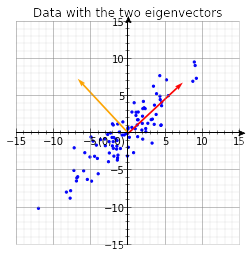

In [26]:
def getMtMandEigenpairs(M):
    MtM = M.transpose() * M
    evals, evectors = eig([MtM]) # Note: eigenvectors are unit vectors
    evals = evals[0]
    evectors = evectors[0]
    return MtM, evals, evectors

# Calculate MtM and the eigenpairs
MtM, evals, evectors = getMtMandEigenpairs(M)

print "M'M:"
print MtM

print
print "Eigenvalues:"
print evals

print
print "Eigenvectors (note: the columns):"
print evectors
    
# Placing the principle eigenvector (one with largest eigenvalue) first, the eigenvector matrix is:
E = np.matrix([evectors[:,0], evectors[:,1]]).transpose()
print
print "Matrix of sorted eigenvectors:"
print E

ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.scatter(M[:,0].A1, M[:,1].A1, s = 5, c = 'blue', edgecolors="face")
plt.xlim(-15, 15)
plt.ylim(-15,15)
ax.quiver([0,0], [0,0], 
          E[0,:].A1, # list of x coordinates
          E[1,:].A1, # list of y coordiates
          angles='xy',scale_units='xy',scale=0.1, color=["red", "orange"])
center_spines()
plt.title("Data with the two eigenvectors")
plt.show()

The 1st principal eigenvector is the axis which, when all the data are projected on it, **shows the largest variance**.  In our example, it is the red vector.

Next we will rotate all the coordinates and we can see the large variance along the principal component.

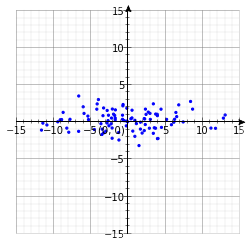

Covariance Matrix of rotated matrix:
[[ 29.3242247    0.09267896]
 [  0.09267896   1.7154616 ]]


In [27]:
ME = M * E # Rotate the date in M by using the new coordiates represented by E.
plotMatrix(ME)

C_ME = np.cov(ME, rowvar=0) # set rowvar=0, meaning each col in A is a variable, and each row is an observation
print "Covariance Matrix of rotated matrix:"
print C_ME

We observed that ME is the points of M transformed into a new coordinate space:
- In this space, the first axis (the one corresponding to the largest eigenvalue) is the most significant; formally, the variance of points along that axis is the greatest. 
- The second axis, corresponding to the second eigenpair, is next most significant in the same sense, and the pattern continues for each of the eigenpairs. 
- If we want to transform M to a space with fewer dimensions, then the choice that preserves the most significance is the one that uses the eigenvectors associated with the largest eigenvalues and ignores the other eigenvalues.
- Moreover, in the new coordinate space, x and y are now uncorrelated, as shown in the figure and in the covariance matrix.  So we can reduce dimension [without worrying about losing information][1] in multiple dimensions.

For example, let's reduce the dimension of M from 2D to 1D.

[1]: http://www.visiondummy.com/2014/05/feature-extraction-using-pca/

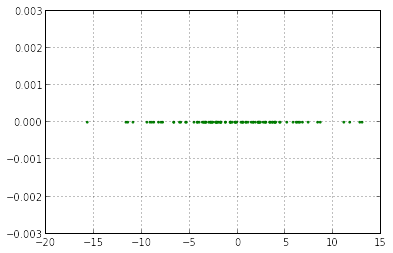

In [28]:
E1 = E[:,0]
M_1D = M * E1

plt.scatter(M_1D[:,0].A1, np.zeros(M_1D.shape[0]), s = 3, c = 'green', edgecolors="face")
plt.grid(True)
plt.show()

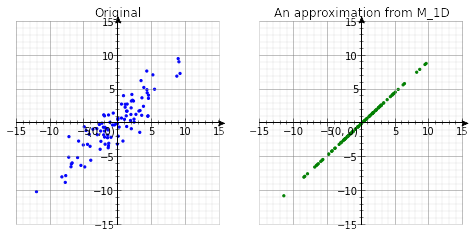

In [29]:
## Recover M from M_1D

M_approx = M_1D * E1.transpose()
plotMatrix([M, M_approx], c=['blue','green'], title=["Original", "An approximation from M_1D"])

## Repeat it using a 3D matrix

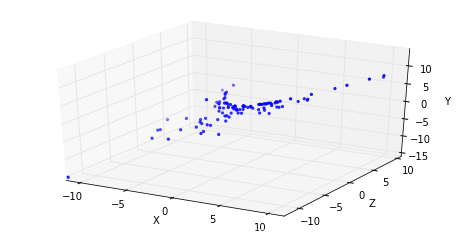

Covariance Matrix:
[[ 19.23375032  16.34081792   0.54873786]
 [ 16.34081792  17.62664343   1.54811403]
 [  0.54873786   1.54811403  14.15296055]]


In [30]:
u = np.random.normal(0, 4, 100)
v = np.random.normal(0, 1, 100)
x = u + v
y = u - v
z = u * v
M = np.matrix(zip(x,y,z))
plot3DMatrix(M)
C = np.cov(M, rowvar=0) # set rowvar=0, meaning each col in A is a variable, and each row is an observation
print "Covariance Matrix:"
print C


In [31]:
MtM, evals, evectors = getMtMandEigenpairs(M)

print
print "Eigenvalues:"
print evals

print
print "Eigenvectors (note: the columns):"
print evectors
    



Eigenvalues:
[ 3454.77583133   206.98672298  1413.94381102]

Eigenvectors (note: the columns):
[[ 0.72172443  0.68505976 -0.0990302 ]
 [ 0.68868146 -0.72505631  0.00334576]
 [ 0.06951043  0.07061498  0.9950788 ]]


In [32]:
evectors[:,[1,2]] = evectors[:,[2,1]] # Let's rank the eigenvectors by the eigenvalues, by swapping 2nd and 3rd cols.
E = evectors
print "Eigenvector matrix, with vectors ordered by eigenvalues:"
print E

Eigenvector matrix, with vectors ordered by eigenvalues:
[[ 0.72172443 -0.0990302   0.68505976]
 [ 0.68868146  0.00334576 -0.72505631]
 [ 0.06951043  0.9950788   0.07061498]]


We will reduce M by using the 1st and 2nd eigenvectors.

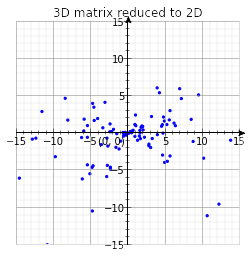

In [33]:
# Multiple a vector by -1 won't affect the property of this eigenvector, but it helps to match the result obtained
# from sklearn.pca
E[:,[1]] = E[:,[1]]*-1

M_reduced = M * E[:,[0,1]]
plotMatrix(M_reduced, title="3D matrix reduced to 2D")


## Let's see what we get from calling sklearn PCA

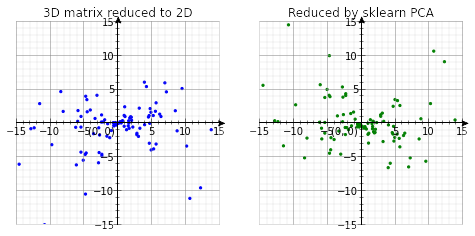

In [34]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, whiten=False)
pca.fit(M)
pca_reduced = pca.transform(M)
plotMatrix([M_reduced, np.matrix(pca_reduced)],c=['blue', 'green'], 
           title=["3D matrix reduced to 2D", "Reduced by sklearn PCA"])

### Approximate M back from M_reduced

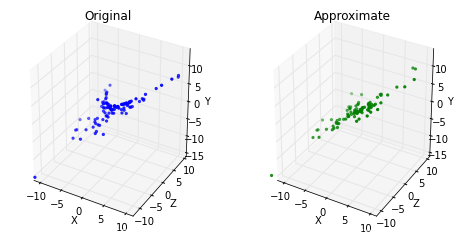

In [35]:
# M_reduced = M * E[:,[0,1]]
# Please note that E[:,[0,1]] * (E[:,[0,1]]).transpose() == I
# More info: http://people.revoledu.com/kardi/tutorial/LinearAlgebra/EigenValueEigenVectorSymmetricMatrix.html
# print E[:, [0,1]] * (E[:, [0,1]]).transpose()

M_approx = M_reduced * (E[:, [0,1]]).transpose()
plot3DMatrix([M, M_approx], c = ['blue', 'green'], title=['Original', 'Approximate'])

In [36]:
print "[Manually] Eigenvectors (transposed):"
print E.transpose()
print
print "[PCA] Eigenvectors:"
print(pca.components_)

print
print "[Manually] Reduced matrix (first 5 rows):"
print M_reduced[0:5]

print
print "[PCA] Reduced matrix (first 5 rows):"
print pca_reduced[0:5]

[Manually] Eigenvectors (transposed):
[[ 0.72172443  0.68868146  0.06951043]
 [ 0.0990302  -0.00334576 -0.9950788 ]
 [ 0.68505976 -0.72505631  0.07061498]]

[PCA] Eigenvectors:
[[ 0.72135978  0.68896205  0.07050793]
 [-0.09344905 -0.00404728  0.99561584]]

[Manually] Reduced matrix (first 5 rows):
[[-3.42843964  0.72204196]
 [-6.28597796 -0.58269278]
 [ 4.59515367 -2.93989888]
 [ 1.97912834  0.4445436 ]
 [-9.81805793 -3.15828053]]

[PCA] Reduced matrix (first 5 rows):
[[-3.3807109  -1.14244105]
 [-6.23673959  0.16120681]
 [ 4.6462308   2.52116091]
 [ 2.02751531 -0.8795552 ]
 [-9.7660987   2.73869889]]


# SVD - Singular Value Decomposition

SVD defines a small number of “concepts” that connect the rows and columns of the matrix:
- By eliminating the least important concepts we get a smaller representation that closely approximates the original matrix. 
- These "concepts" can be used to query the original matrix more efficiently.

### Rank

Rank is the number of rows (or columns) in a matrix which are *independent*.

In [37]:
A = np.matrix([
        [1, 2, 1, 0],
        [2, 4, 5, 1],
        [3, 6, 7, -2],
        [4, 8, 2, 5]
    ])

# Rank = 3 because col-1 is col-0 * 2
print "Rank(A) =", linalg.matrix_rank(A)

A1 = A.copy()
A1[:,3] = A1[:,0]*5 - A1[:,2]*2 # Moreover, col-3 = 5*col-0 - 2*col-2
print "Rank(A1) =", linalg.matrix_rank(A1) 


Rank(A) = 3
Rank(A1) = 2


### Decomposition

Assume we have a user-movie matrix, where the values are movie ratings.
<img src="files/movie-ratings-1.png" style="height:250px">


In [38]:
A = np.matrix([
        [1,1,1,0,0],
        [3,3,3,0,0],
        [4,4,4,0,0],
        [5,5,5,0,0],
        [0,0,0,4,4],
        [0,0,0,5,5],
        [0,0,0,2,2],
    ])

import scipy.sparse as sp
M = sp.lil_matrix((A.shape[0], A.shape[1]))

for i in range(A.shape[0]):
    M[i] = A[i,:]
    

In [39]:
# Assume rank = 2
# Let's do an SVD decomposition
from scipy.sparse.linalg import svds

np.set_printoptions(precision=3, suppress=True)
U, S, V = svds(M, k=2)
S = np.diag(S)
print "U, S, V':\n"
print U
print
print S
print
print V

U, S, V':

[[-0.     0.14 ]
 [-0.     0.42 ]
 [-0.     0.56 ]
 [-0.     0.7  ]
 [ 0.596  0.   ]
 [ 0.745  0.   ]
 [ 0.298  0.   ]]

[[  9.487   0.   ]
 [  0.     12.369]]

[[-0.    -0.     0.     0.707  0.707]
 [ 0.577  0.577  0.577  0.     0.   ]]


In [430]:
# Please note that we can also use linalg.svd.  But we have to drop the zero singular values
u, s, v = linalg.svd(A)
print u
print
print s
print
print v
print

[[-0.14   0.     0.417 -0.56  -0.42   0.522  0.209]
 [-0.42   0.     0.154 -0.206  0.845  0.192  0.077]
 [-0.56   0.     0.205  0.725 -0.206  0.256  0.103]
 [-0.7    0.    -0.34  -0.344 -0.258 -0.425 -0.17 ]
 [ 0.    -0.596  0.644  0.     0.    -0.444 -0.178]
 [ 0.    -0.745 -0.444  0.     0.     0.444 -0.222]
 [ 0.    -0.298 -0.178  0.     0.    -0.222  0.911]]

[ 12.369   9.487   0.      0.      0.   ]

[[-0.577 -0.577 -0.577 -0.    -0.   ]
 [-0.    -0.    -0.    -0.707 -0.707]
 [ 0.     0.     0.    -0.707  0.707]
 [ 0.    -0.707  0.707  0.     0.   ]
 [ 0.816 -0.408 -0.408  0.     0.   ]]



In [431]:
print "From sparse.svds:"
print "U, S, V':\n"
print U
print
print S
print
print V
print
print "From linalg.svd, after dropping the zero singular values"
print u[:,:2]
print
print np.diag(s[:2])
print
print v[:2,:]

From sparse.svds:
U, S, V':

[[ 0.     0.14 ]
 [ 0.     0.42 ]
 [ 0.     0.56 ]
 [ 0.     0.7  ]
 [ 0.596 -0.   ]
 [ 0.745 -0.   ]
 [ 0.298 -0.   ]]

[[  9.487   0.   ]
 [  0.     12.369]]

[[ 0.     0.    -0.     0.707  0.707]
 [ 0.577  0.577  0.577  0.    -0.   ]]

From linalg.svd, after dropping the zero singular values
[[-0.14   0.   ]
 [-0.42   0.   ]
 [-0.56   0.   ]
 [-0.7    0.   ]
 [ 0.    -0.596]
 [ 0.    -0.745]
 [ 0.    -0.298]]

[[ 12.369   0.   ]
 [  0.      9.487]]

[[-0.577 -0.577 -0.577 -0.    -0.   ]
 [-0.    -0.    -0.    -0.707 -0.707]]


<img src="files/movie-ratings-1.png" style="height:180px">

Above, we can see that there are two concepts:
- S gives the strength of each of the concepts. 
    - In our example, the strength of the science-fiction concept is 12.4, while the strength of the romance concept is 9.5. 
    - Intuitively, the science-fiction concept is stronger because the data provides more information about the movies of that genre and the people who like them.
- Each row in U represents a user, with her preference for each concept.
- Each col in V represents a move, with its closeness to each concept.
    


## More realistic example

The matrix above can be divided into two ranks too obviously.  Let's modify the matrix so that it's a bit more realistic.

In [432]:
A = np.matrix([
        [1,1,1,0,0],
        [3,3,3,0,0],
        [4,4,4,0,0],
        [5,5,5,0,0],
        [0,2,0,4,4],
        [0,0,0,5,5],
        [0,1,0,2,2],
    ])

import scipy.sparse as sp
M = sp.lil_matrix((A.shape[0], A.shape[1]))

for i in range(A.shape[0]):
    M[i] = A[i,:]

U, S, V = svds(M, k=3)
S = np.diag(S)
print "U, S, V':\n"
print U
print
print S
print
print V

U, S, V':

[[-0.011  0.024  0.138]
 [-0.032  0.071  0.413]
 [-0.043  0.094  0.55 ]
 [-0.054  0.118  0.688]
 [ 0.654 -0.591  0.153]
 [-0.678 -0.731  0.072]
 [ 0.327 -0.296  0.076]]

[[  1.346   0.      0.   ]
 [  0.      9.509   0.   ]
 [  0.      0.     12.481]]

[[-0.41   0.805 -0.41  -0.091 -0.091]
 [ 0.127 -0.029  0.127 -0.695 -0.695]
 [ 0.562  0.593  0.562  0.09   0.09 ]]


<img src="files/movie-ratings-2.png" style="height:180px">

We can observe that:
- The 2nd and 3rd columns of S still corresponds to "romance" and "sci-fi". 
- The 1st column of S isn't so clear.  However, it has a small weight and so it's not so significant.

## Dimensionality Reduction

Suppose we want to drop to 2 columns.  We do it by setting smallest singular value (i.e. 1.3) to zero.  It has the same effect as setting the 1st column of U and the 3rd row of V' to zero.  In matrix calculation, it is the same as dropping the 1st column of U, the 1st col + 1st row of S, and the 3rd row of V.

In [433]:
Uc = U[:,1:3]
Sc = S[1:,1:]
Vc = V[1:,:]
M_approx = np.dot(np.dot(Uc, Sc), Vc)

print "Approximated by dropping the least singular value:"
print M_approx

Approximated by dropping the least singular value:
[[ 0.994  1.012  0.994 -0.001 -0.001]
 [ 2.982  3.035  2.982 -0.004 -0.004]
 [ 3.976  4.047  3.976 -0.005 -0.005]
 [ 4.97   5.059  4.97  -0.007 -0.007]
 [ 0.36   1.292  0.36   4.08   4.08 ]
 [-0.374  0.734 -0.374  4.917  4.917]
 [ 0.18   0.646  0.18   2.04   2.04 ]]


<img src="files/movie-ratings-2.png" style="height:180px">


## Make a prediction for a new user

Suppose a new user **x** comes in, with no info except a rating of 4 for the movie "Matrix".  We can predict his ratings for other movies.

In [434]:
x = np.array([4,0,0,0,0]).reshape(1,-1)

print "Reminder: shapes of Uc, Sc and Vc:", Uc.shape, Sc.shape, Vc.shape
print

# His preference in our concept space
conceptPref = np.dot(x, Vc.transpose())
print "Taste in our concept space:", conceptPref

# An approximation of his ratings by mapping the taste back to a row in original ratings
approxRatings = np.dot(conceptPref, Vc)
print "Approximated ratings: ", approxRatings


Reminder: shapes of Uc, Sc and Vc: (7, 2) (2, 2) (2, 5)

Taste in our concept space: [[ 0.507  2.249]]
Approximated ratings:  [[ 1.329  1.319  1.329 -0.15  -0.15 ]]


## Compare taste of users and find similar users

<img src="files/movie-ratings-2.png" style="height:180px">


In [436]:
joe = A[0,:]
jack = A[3,:]
jenny = A[5,:]
jane = A[6, :]

import scipy.spatial.distance as distance

# Compare the taste of two users by transforming them to the concept space, and then calculate
# the cosine distance between their concept-vectors.
def compareTaste(a, b):
    conceptA = np.dot(a, Vc.transpose())
    conceptB = np.dot(b, Vc.transpose())
    print "Cosine distance =", distance.cosine(conceptA, conceptB)
    
compareTaste(joe, jack)
compareTaste(joe, jane)
compareTaste(jenny, jane)

Cosine distance = -2.22044604925e-16
Cosine distance = 0.80419710887
Cosine distance = 0.0195712915024
